In [1]:
#----------------------------#
# 0.) Idea
#----------------------------#
# Analyze Get submssion deletion boundaries
#

#
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import math
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import statsmodels.api as sm

In [2]:
home_path = %pwd
data_path = "/home/pavel/Documents/Keusch_Job/Data/"
plot_path  = "/home/pavel/Documents/Keusch_Job/Tasks/deletion_boundaries/"
subroutines_path = "/home/pavel/Documents/Keusch_Job/Subroutines/"

In [3]:
#Subroutines
%cd  $subroutines_path
%run "selected_subreddits.ipynb"
%run "data_loader.ipynb"
%run "basic_plots.ipynb"
%cd  $home_path

/home/pavel/Documents/Keusch_Job/Subroutines
/home/pavel/Documents/Keusch_Job/Tasks/deletion_boundaries


In [4]:
S = load_data(data_name="SUBM_2020_01.csv", data_path = data_path)
S.head()

,author,created_utc,domain,full_link,id,is_crosspostable,is_self,is_video,num_comments,post_hint,score,selftext,subreddit,title,url,removed_by_category,link_flair_text
0,sixwaystop313,2019-12-31 22:03:48,imgur.com,https://www.reddit.com/r/Michigan/comments/ei8...,t3_ei8t50,True,False,False,8,link,1,NaN,Michigan,TIL in Traverse City skateboards and rollerbla...,https://imgur.com/JCMkFWh,NaN,NaN
1,livya15,2019-12-31 23:15:10,self.Michigan,https://www.reddit.com/r/Michigan/comments/ei9...,t3_ei9p65,True,True,False,0,NaN,1,https://www.facebook.com/83040292558/posts/101...,Michigan,Could you imagine if a sign like this was post...,https://www.reddit.com/r/Michigan/comments/ei9...,NaN,NaN
2,livya15,2020-01-01 00:03:54,nbc25news.com,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaaut,True,False,False,1,link,1,NaN,Michigan,Could you imagine if there was a sign placed a...,https://nbc25news.com/news/local/lapeer-county...,NaN,NaN
3,lishmunchkin,2020-01-01 00:10:24,self.Michigan,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaduh,True,True,False,4,NaN,1,Hubby and I are moving to Michigan in 2 weeks ...,Michigan,Hoping the new year brings good things!,https://www.reddit.com/r/Michigan/comments/eia...,NaN,NaN
4,DonSlice,2020-01-01 00:35:11,i.imgur.com,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaow3,True,False,False,6,NaN,1,NaN,Michigan,"Welcome back, Winter. You’ve been gone a while.",https://i.imgur.com/LZcd5IR.jpg,NaN,NaN


In [5]:
#Manual check of links to chack validity of classification
#print(S[["full_link"]].loc[S["removed_by_category"]=="reddit",].iloc[100:200,].to_string())

In [6]:
#print(S[["full_link"]].loc[S["removed_by_category"]=="deleted",].iloc[0:100,].to_string())

In [7]:
#----------------------------#
# 1.)  Prob deletion Descriptives
#----------------------------#

In [8]:
# I would argue to keep automod_filtered, since it is still set by the mods from what I see
#https://www.reddit.com/r/AutoModerator/comments/q11pu/what_is_automoderator/
# "Remove submissions where the title contains certain words or phrases"
#Some basic Stats
print("Length of Submission Data: " + str(len(S)))
print("Passible removed_by_category outputs" + str(S["removed_by_category"].unique()))
S_grouped = S.groupby(["removed_by_category"]).size().reset_index()
print(S_grouped.to_string())
print("Amount deleted: " + str(S_grouped[0].sum()))

Length of Submission Data: 404631
Passible removed_by_category outputs[nan 'moderator' 'reddit' 'deleted' 'automod_filtered' 'author']
  removed_by_category      0
0              author      8
1    automod_filtered  13926
2             deleted   5511
3           moderator  61406
4              reddit  37437
Amount deleted: 118288


In [9]:
S["removed"] = 1 
S.loc[S["removed_by_category"].isna(),"removed"] = 0 
S_grouped = S.groupby(["subreddit","removed"]).size().reset_index()
S_grouped.columns = ["subreddit","removed","count"]
print(len(S_grouped.loc[S_grouped["removed"] == 1,]))
print(len(S_grouped.loc[S_grouped["removed"] == 0,]))
print("Each subreddit has deleted at least one submission")

78
78
Each subreddit has deleted at least one submission


In [10]:
#
S["removed_automod"] = 0
S.loc[S["removed_by_category"] == "automod_filtered","removed_automod"] = 1
print(S["removed_automod"].unique())
#
S["removed_deleted"] = 0
S.loc[S["removed_by_category"] == "deleted","removed_deleted"] = 1
print(S["removed_deleted"].unique())
#
S["removed_moderator"] = 0
S.loc[S["removed_by_category"] == "moderator","removed_moderator"] = 1
print(S["removed_moderator"].unique())
#
S["removed_reddit"] = 0
S.loc[S["removed_by_category"] == "reddit","removed_reddit"] = 1
print(S["removed_reddit"].unique())

[0 1]
[0 1]
[0 1]
[0 1]


In [11]:
#----------------------------#
# 2.) Get Embeddings and PCA Data
#----------------------------#

In [12]:
# I've computed this back then in subreddit_submission
embed_dict = np.load(data_path + 'embed_dict.npy',allow_pickle='TRUE').item()

In [13]:
def get_subreddit_embeddings(c_S):
    #c_S: current subreddit
    local_embed_list = []
    id_list = c_S["id"].unique().tolist()
    [local_embed_list.append(embed_dict[x]) for x in id_list]
    return(local_embed_list)

In [14]:
def subr_dict_2_matrix(s_dict, key_list):
    #s_dict: some dictionary where the values are embedings ()
    #key_list: a list of keys
    #RETURNS: the np.array matrix where each value is a row.
    emb_matrix = np.append(s_dict[key_list[0]], s_dict[key_list[1]],axis=0)
    for i in range(2,len(key_list)):
        emb_matrix = np.append(emb_matrix, s_dict[key_list[i]],axis=0)
    return(emb_matrix)

In [15]:
from sklearn.decomposition import PCA

In [16]:
def PCA_data(subr_string):
    #Get DF's
    sub_df = S.loc[S["subreddit"]==subr_string,].copy()
    sub_emb_matrix  = subr_dict_2_matrix(s_dict = embed_dict, key_list= sub_df["id"].tolist()).T
    print(sub_emb_matrix.shape)  
    #PCA
    model = PCA(n_components=2).fit(sub_emb_matrix)
    category_vectors = model.components_.T
    sub_df["dim_x_PCA"] = category_vectors[:,0].tolist()
    sub_df["dim_y_PCA"] = category_vectors[:,1].tolist()
    #sub_df[["id","removed","dim_x_PCA","dim_y_PCA"]]
    return(sub_df)

In [17]:
#Prepare Tet data

In [18]:
democrats_df = PCA_data("democrats")
conservative_df = PCA_data("Conservative")
healthIT_df = PCA_data("healthIT")
atheism_df = PCA_data("atheism")

(512, 1439)
(512, 8596)
(512, 472)
(512, 5350)


In [19]:
democrats_df["color"] = "blue"
democrats_df.loc[democrats_df["removed"]==1 , "color"]= "red"
conservative_df["color"] = "blue"
conservative_df.loc[conservative_df["removed_automod"]==1 , "color"]= "red"
healthIT_df["color"] = "blue"
healthIT_df.loc[healthIT_df["removed_reddit"]==1 , "color"]= "red"
atheism_df["color"] = "blue"
atheism_df.loc[atheism_df["removed_automod"]==1 , "color"]= "red"

In [20]:
#----------------------------#
# 3.) Apply do boundaries
#----------------------------#

In [21]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [22]:
#thx to https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlibt
#and https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.patches.Circle.html
# thx to https://stackoverflow.com/questions/47391702/matplotlib-making-a-colored-markers-legend-from-scratch
# thx https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
def create_legend(labels, colors):
    #colors = ['black', 'red', 'green']
    plot_object = [Line2D([0], [0], color=c, linewidth=3,ls="", marker="o") for c in colors]
    #labels = ['black data', 'red data', 'green data']
    plt.legend(plot_object, labels)

In [23]:
def boundary_logit(df, dv_string, give_params=False, give_pseudo_r = False):
    #run logit
    predictors = sm.add_constant(df[["dim_x_PCA","dim_y_PCA"]])
    logit_model=sm.Logit(df[dv_string],predictors)
    result=logit_model.fit()
    intercept = result.params[0]
    parameters =  result.params[1:3]
    if give_params:
        coef_list=[]
        coef_list.append(intercept)
        coef_list.append(parameters[0])
        coef_list.append(parameters[1])
        if give_pseudo_r==True:
        # Ok so this is the formula for pseudo  r2
        # https://github.com/statsmodels/statsmodels/issues/5861
        #https://statisticalhorizons.com/r2logistic
            coef_list.append(1 - result.llf/result.llnull)
        return(coef_list)
    else:
        min_x1 = df["dim_x_PCA"].min() #-0.02
        min_x2 = df["dim_y_PCA"].min() #-0.02
        return([min_x1,(-intercept/ (parameters[0]*parameters[1]*min_x1))],  
               [(-intercept/(parameters[0]*parameters[1]*min_x2)),min_x2])

In [24]:
boundary_logit(democrats_df, "removed",give_params=True, give_pseudo_r = True)

Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 5


[0.9958988007677126,
 59.12695199728661,
 -3.497192290429297,
 0.05146125094464549]

In [25]:
def descriptives_2D(array_2D):
    #get avg_vector
    avg_vec = array_2D[0]
    for a in array_2D:
        avg_vec = a + avg_vec
    avg_vec = avg_vec /  array_2D.shape[0]
    #compute distances
    distances = []
    for x in array_2D:
        distances.append(np.linalg.norm(avg_vec-x)) # take euclidian distance
        #thx to https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    return(avg_vec, max(distances))

In [26]:
#Test
test_mean, test_max_distance = descriptives_2D(democrats_df[["dim_x_PCA","dim_y_PCA"]].to_numpy())
print(test_mean)
print(test_max_distance)

[-0.02477571 -0.00102234]
0.06402310194731922


In [27]:
#https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Circle.html

In [28]:
#thx to https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib
def scatterplot(df, path,file_name="Democrats_PCA", 
                    main_title="Democrats PCA", 
                    labels = ["Posted","Deleted"], colors =["blue","red"],
                    dv_string = "remove",
                    plot_circle=False,
                    plot_range = 0.1,
                    display_plot = True):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(df["dim_x_PCA"],df["dim_y_PCA"],color= df["color"], s= 10)
    ax = plt.gca()
    create_legend(labels = labels, colors = colors)
    plt.title(main_title, size=20)
    plt.xlabel("X1", size=15)
    plt.ylabel("X2", size=15)
    ## plot decision boundary
    if dv_string != False:
        x1, x2 = boundary_logit(df = df, dv_string = dv_string, give_params = False)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], label='Decision Boundary', color="black")
    if plot_circle==True:
        #thx to https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
        mean, max_distance = descriptives_2D(df[["dim_x_PCA","dim_y_PCA"]].to_numpy())
        circle = plt.Circle((mean[0], mean[1]), max_distance, color='b', fill=False)
        ax.add_artist(circle)
        ax.set_xlim((mean[0] - max_distance - plot_range ,mean[0] + max_distance + plot_range ))
        ax.set_ylim((mean[1] - max_distance - plot_range ,mean[1] + max_distance + plot_range ))
    plt.savefig(fname=path + file_name , dpi = 300)
    if not display_plot:
        # thx to https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
        plt.close(fig) 

Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 5


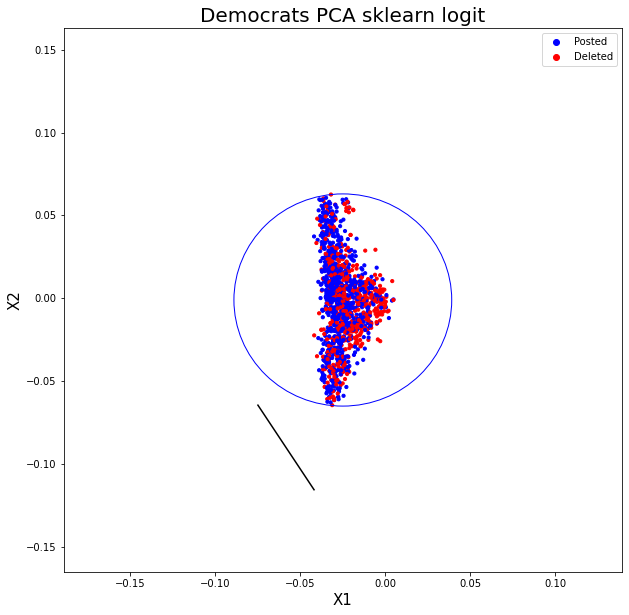

In [29]:
%matplotlib inline
scatterplot(df = democrats_df, path = plot_path,
            #path = plot_path + "PCA_removal/",
            file_name = "Democrats_PCA", main_title = "Democrats PCA logit",
            labels = ["Posted","Deleted"], colors =["blue","red"],
            #dv_string = "removed",
            dv_string = "removed",
            plot_circle=True,
            plot_range = 0.1,
            display_plot = True)

Optimization terminated successfully.
         Current function value: 0.480349
         Iterations 7


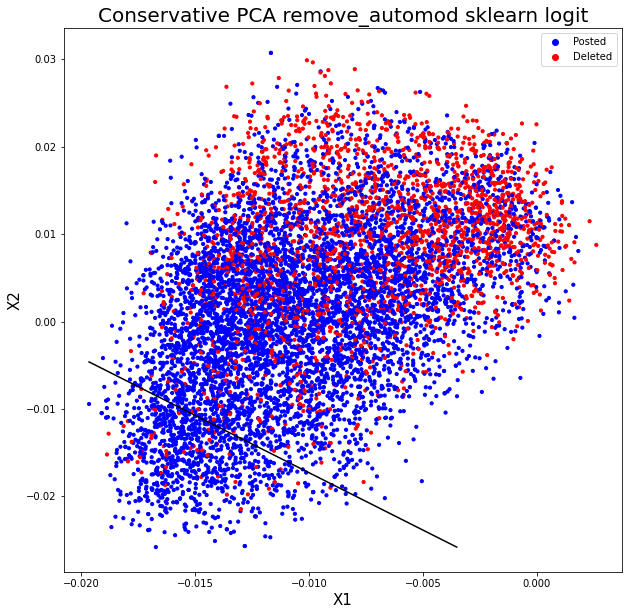

In [30]:
scatterplot(df = conservative_df, path = plot_path,
            #path = plot_path + "PCA_removal/",
            file_name = "Conservative_PCA", main_title = "Conservative PCA remove_automod sklearn logit",
            labels = ["Posted","Deleted"], colors =["blue","red"],
            dv_string = "removed_automod",
            plot_circle=False,
            plot_range = 0,
            display_plot = True)

Optimization terminated successfully.
         Current function value: 0.359733
         Iterations 7


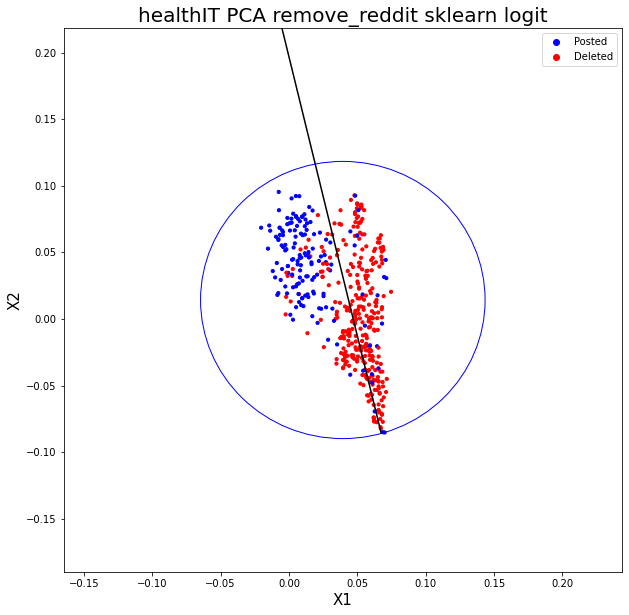

In [31]:
scatterplot(df = healthIT_df, path = plot_path,
            #path = plot_path + "PCA_removal/",
            file_name = "healthIT_PCA", main_title = "healthIT PCA remove_reddit sklearn logit",
            labels = ["Posted","Deleted"], colors =["blue","red"],
            dv_string = "removed_reddit", 
            plot_circle = True,
            display_plot = True)

Optimization terminated successfully.
         Current function value: 0.027446
         Iterations 11


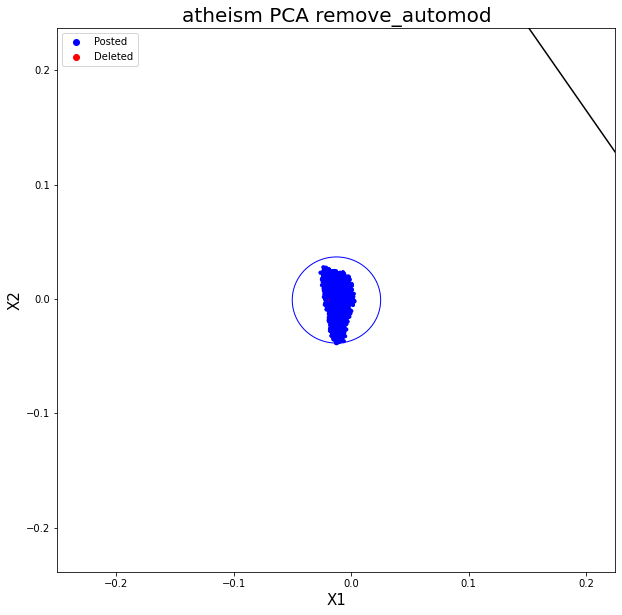

In [32]:
scatterplot(df = atheism_df, path = plot_path,
            #path = plot_path + "PCA_removal/",
            file_name = "atheism_PCA", main_title = "atheism PCA remove_automod",
            labels = ["Posted","Deleted"], colors =["blue","red"],
            dv_string = "removed_automod", 
            plot_circle = True,
            plot_range = 0.2,
            display_plot = True)

In [33]:
#----------------------------#
# 5.) check cirle crossing
#----------------------------#

In [34]:
#WARNING: we actually want to estimate an elipse
# Check out:
#http://exnumerus.blogspot.com/2011/03/python-script-to-fit-ellipse-to-noisy.html
#https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points
#https://www.emis.de/journals/BBMS/Bulletin/sup962/gander.pdf
#http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html

In [35]:
# Solution taken from
#https://www.geeksforgeeks.org/check-line-touches-intersects-circle/
#https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
def checkCollision(a, b, c, x, y, radius):    
    # Finding the distance of line  
    # from center. 
    dist = ((abs(a * x + b * y + c)) /
            math.sqrt(a * a + b * b)) 
  
    # Checking if the distance is less  
    # than, greater than or equal to radius. 
    if (radius >= dist): 
        print("Touch")
        return(1)
    else: 
        print("Outside") 
        return(0)

In [36]:
def check_df_collision(df, dv_string):
    mean, max_distance = descriptives_2D(df[["dim_x_PCA","dim_y_PCA"]].to_numpy())
    params = boundary_logit(df = df, dv_string = dv_string, give_params = True)
    #print("Mean Vector: " + str(mean))
    #print("Range: " + str(max_distance))
    #print(params)
    return(checkCollision(params[1],params[2],params[0],
               mean[0],mean[1],max_distance ))

In [37]:
print(check_df_collision(democrats_df, "removed"))
print(check_df_collision(conservative_df, "removed_automod"))
print(check_df_collision(healthIT_df, "removed_reddit"))
print(check_df_collision(atheism_df, "removed_automod"))

Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 5
Touch
1
Optimization terminated successfully.
         Current function value: 0.480349
         Iterations 7
Touch
1
Optimization terminated successfully.
         Current function value: 0.359733
         Iterations 7
Touch
1
Optimization terminated successfully.
         Current function value: 0.027446
         Iterations 11
Outside
0


In [38]:
boundary_logit(df = democrats_df, dv_string = "removed", give_params = True, give_pseudo_r=True)

Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 5


[0.9958988007677126,
 59.12695199728661,
 -3.497192290429297,
 0.05146125094464549]

In [39]:
#----------------------------#
# 6.) Run for all
#----------------------------#

In [51]:
removed_var_list = ["removed","removed_automod","removed_deleted","removed_moderator","removed_reddit"]
removed_var_list

['removed',
 'removed_automod',
 'removed_deleted',
 'removed_moderator',
 'removed_reddit']

In [65]:
#
S["boundary"] = 0
S["boundary_automod"] = 0
S["boundary_deleted"] = 0
S["boundary_moderator"] = 0
S["boundary_reddit"] = 0
#
S["pseudo_r_removed"] = 999 # the overall one
S["pseudo_r_automod"] = 999
S["pseudo_r_deleted"] = 999
S["pseudo_r_moderator"] = 999
S["pseudo_r_reddit"] = 999

In [42]:
democrats_df = PCA_data("democrats")
conservative_df = PCA_data("Conservative")
healthIT_df = PCA_data("healthIT")
atheism_df = PCA_data("atheism")

(512, 1439)
(512, 8596)
(512, 472)
(512, 5350)


In [60]:
def mark_subreddit_boundaries(subreddit):
    subr_df = PCA_data(subreddit)
    boundary_list = []
    pseudo_r_list = []
    for r in removed_var_list:
        #there were some with no deleteions at all in particular categories , 
        # e.g health IT with automod
        #
        if len(subr_df.loc[subr_df[r]==1,]) == 0:
            boundary_list.append(0)
            pseudo_r_list.append(0)
        else:
            boundary_list.append(check_df_collision(subr_df, r)) #should I use a dictionary here?
            pseudo_r_list.append(boundary_logit(df = subr_df, dv_string = r, 
                                        give_params = True, give_pseudo_r=True)[3])
    return(boundary_list, pseudo_r_list)

In [61]:
#Test
boundary_test, pseudo_r_test = mark_subreddit_boundaries("democrats")
print("Output")
print(boundary_test)
print(pseudo_r_test)

(512, 1439)
Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 5
Touch
Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.152623
         Iterations 8
Outside
Optimization terminated successfully.
         Current function value: 0.152623
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.079758
         Iterations 9
Outside
Optimization terminated successfully.
         Current function value: 0.079758
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.468399
         Iterations 6
Touch
Optimization terminated successfully.
         Current function value: 0.468399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410016
         Iterations 6
Touch
Optimization terminated successfully

In [ ]:
# Run for all

In [57]:
subr_list = S["subreddit"].unique().tolist()

In [62]:
removed_var_list

['removed',
 'removed_automod',
 'removed_deleted',
 'removed_moderator',
 'removed_reddit']

In [66]:
for s in subr_list:
    print(s)
    boundary_test, pseudo_r_test = mark_subreddit_boundaries(s)
    S.loc[S["subreddit"]==s,"boundary"] = boundary_test[0]
    S.loc[S["subreddit"]==s,"boundary_automod"] = boundary_test[1]
    S.loc[S["subreddit"]==s,"boundary_deleted"] = boundary_test[2]
    S.loc[S["subreddit"]==s,"boundary_moderator"] = boundary_test[3]
    S.loc[S["subreddit"]==s,"boundary_reddit"] = boundary_test[4]
    #
    S.loc[S["subreddit"]==s,"pseudo_r_removed"] = pseudo_r_test[0]
    S.loc[S["subreddit"]==s,"pseudo_r_automod"] = pseudo_r_test[1]
    S.loc[S["subreddit"]==s,"pseudo_r_deleted"] = pseudo_r_test[2]
    S.loc[S["subreddit"]==s,"pseudo_r_moderator"] = pseudo_r_test[3]
    S.loc[S["subreddit"]==s,"pseudo_r_reddit"] = pseudo_r_test[4]

Michigan
(512, 765)
Optimization terminated successfully.
         Current function value: 0.212142
         Iterations 8
Touch
Optimization terminated successfully.
         Current function value: 0.212142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055702
         Iterations 9
Outside
Optimization terminated successfully.
         Current function value: 0.055702
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.104955
         Iterations 9
Touch
Optimization terminated successfully.
         Current function value: 0.104955
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.110172
         Iterations 9
Outside
Optimization terminated successfully.
         Current function value: 0.110172
         Iterations 9
PoliticalVideo
(512, 1046)
Optimization terminated successfully.
         Current function value: 0.322183
         Iterations 7
Touch
O

Optimization terminated successfully.
         Current function value: 0.047152
         Iterations 9
Outside
Optimization terminated successfully.
         Current function value: 0.047152
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.403352
         Iterations 6
Outside
Optimization terminated successfully.
         Current function value: 0.403352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683223
         Iterations 4
Touch
Optimization terminated successfully.
         Current function value: 0.683223
         Iterations 4
usanews
(512, 1031)
Optimization terminated successfully.
         Current function value: 0.517851
         Iterations 6
Touch
Optimization terminated successfully.
         Current function value: 0.517851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604786
         Iterations 6
Touch
Optimization terminated succ

Economics
(512, 1469)
Optimization terminated successfully.
         Current function value: 0.390985
         Iterations 6
Touch
Optimization terminated successfully.
         Current function value: 0.390985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.054529
         Iterations 10
Touch
Optimization terminated successfully.
         Current function value: 0.054529
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.272479
         Iterations 7
Touch
Optimization terminated successfully.
         Current function value: 0.272479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181098
         Iterations 8
Touch
Optimization terminated successfully.
         Current function value: 0.181098
         Iterations 8
EverythingScience
(512, 1089)
Optimization terminated successfully.
         Current function value: 0.441420
         Iterations 6
Touc

Optimization terminated successfully.
         Current function value: 0.037830
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.579493
         Iterations 6
Touch
Optimization terminated successfully.
         Current function value: 0.579493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031067
         Iterations 10
Outside
Optimization terminated successfully.
         Current function value: 0.031067
         Iterations 10
SEO
(512, 2888)
Optimization terminated successfully.
         Current function value: 0.633077
         Iterations 6
Touch
Optimization terminated successfully.
         Current function value: 0.633077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025789
         Iterations 11
Touch
Optimization terminated successfully.
         Current function value: 0.025789
         Iterations 11
Optimization terminated successfull

Optimization terminated successfully.
         Current function value: 0.064087
         Iterations 10
Touch
Optimization terminated successfully.
         Current function value: 0.064087
         Iterations 10
australia
(512, 12873)
Optimization terminated successfully.
         Current function value: 0.586037
         Iterations 5
Touch
Optimization terminated successfully.
         Current function value: 0.586037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.159696
         Iterations 8
Outside
Optimization terminated successfully.
         Current function value: 0.159696
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508239
         Iterations 6
Outside
Optimization terminated successfully.
         Current function value: 0.508239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138713
         Iterations 9
Outside
Optimization terminat

Optimization terminated successfully.
         Current function value: 0.042254
         Iterations 10
Outside
Optimization terminated successfully.
         Current function value: 0.042254
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.252366
         Iterations 8
Touch
Optimization terminated successfully.
         Current function value: 0.252366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.149087
         Iterations 8
Touch
Optimization terminated successfully.
         Current function value: 0.149087
         Iterations 8
europe
(512, 6767)
Optimization terminated successfully.
         Current function value: 0.450986
         Iterations 6
Touch
Optimization terminated successfully.
         Current function value: 0.450986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.212620
         Iterations 8
Outside
Optimization terminated suc

metacanada
(512, 2303)
Optimization terminated successfully.
         Current function value: 0.367092
         Iterations 6
Outside
Optimization terminated successfully.
         Current function value: 0.367092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.289808
         Iterations 7
Outside
Optimization terminated successfully.
         Current function value: 0.289808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040802
         Iterations 10
Outside
Optimization terminated successfully.
         Current function value: 0.040802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.110185
         Iterations 9
Outside
Optimization terminated successfully.
         Current function value: 0.110185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036725
         Iterations 10
Outside
Optimization ter

Optimization terminated successfully.
         Current function value: 0.220040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.057361
         Iterations 9
Outside
Optimization terminated successfully.
         Current function value: 0.057361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.379415
         Iterations 7
Touch
Optimization terminated successfully.
         Current function value: 0.379415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019326
         Iterations 12
Touch
Optimization terminated successfully.
         Current function value: 0.019326
         Iterations 12
pakistan
(512, 2432)
Optimization terminated successfully.
         Current function value: 0.687973
         Iterations 4
Touch
Optimization terminated successfully.
         Current function value: 0.687973
         Iterations 4
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.188189
         Iterations 8
Outside
Optimization terminated successfully.
         Current function value: 0.188189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201799
         Iterations 8
Outside
Optimization terminated successfully.
         Current function value: 0.201799
         Iterations 8
ukpolitics
(512, 5003)
Optimization terminated successfully.
         Current function value: 0.335788
         Iterations 7
Touch
Optimization terminated successfully.
         Current function value: 0.335788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037466
         Iterations 10
Outside
Optimization terminated successfully.
         Current function value: 0.037466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049267
         Iterations 10
Outside
Optimization termi

Optimization terminated successfully.
         Current function value: 0.346803
         Iterations 7
Touch
Optimization terminated successfully.
         Current function value: 0.346803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178048
         Iterations 8
Outside
Optimization terminated successfully.
         Current function value: 0.178048
         Iterations 8


In [ ]:
#TO DO
# s1: Should I use a dictionary in the loop?
# s2: Maybe  first get the PCA for everyone and update the dataframe, the I don't have to do it for each one separete
# or just save the current dataframe with all the markings?
# In scatterplot() I am not computing the PCA again, only rerunning logit, but this should be fine
# s3: in legend automod_deleted

In [69]:
S.describe()

,num_comments,score,removed,removed_automod,removed_deleted,removed_moderator,removed_reddit,boundary_automod,boundary_deleted,boundary_moderator,boundary_reddit,boundary,pseudo_r_removed,pseudo_r_automod,pseudo_r_deleted,pseudo_r_moderator,pseudo_r_reddit
count,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000,404631.000000
mean,26.772721,15.165645,0.292335,0.034417,0.013620,0.151758,0.092521,0.165669,0.099387,0.466917,0.421441,0.664638,0.039435,0.020955,0.016861,0.022184,0.043156
std,297.608175,583.948683,0.454836,0.182297,0.115907,0.358787,0.289761,0.371784,0.299181,0.498905,0.493790,0.472118,0.042922,0.034251,0.025846,0.027269,0.047632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000199,0.000000,0.000000,0.000000,0.000593
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006903,0.000000,0.003356,0.002081,0.006915
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.025850,0.004796,0.006013,0.011334,0.026714
75%,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.040897,0.021685,0.023629,0.036742,0.087025
max,64294.000000,105205.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.160955,0.145608,0.317308,0.299190,0.430357
